# PGE HACKATHON 2022

Import Required Packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from scipy.optimize import curve_fit

import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python  

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score  # specific measures to check our models
from sklearn.model_selection import train_test_split      # train and test split
from sklearn.impute import KNNImputer     # k-nearest neighbour imputation method
from scipy.interpolate import griddata

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import (PolynomialFeatures, MaxAbsScaler, 
                                   MinMaxScaler, StandardScaler, RobustScaler)
from sklearn.linear_model import LinearRegression, ElasticNet 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error
from scipy import linalg  
from scipy import stats 
# sns.set(rc={'text.usetex' : True})

#### Declare functions

Let's define a couple of functions to streamline plotting correlation matrices and visualization of a machine learning regression model responce over the 2 predictor features. 

In [2]:
def plot_corr(dataframe,size=10):                         # plots a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    
def visualize_model(model,xfeature,yfeature,response,title,):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.RdYlBu
    plot_step = 0.02
    x_min, x_max = min(xfeature) - 1, max(xfeature) + 1
    y_min, y_max = min(yfeature) - 1, max(yfeature) + 1
    resp_min = round(min(response)); resp_max = round(max(response));
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    z_min = round(min(response)); z_max = round(max(response))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max)

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    return(plt)

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.  

In [3]:
well_logs_df = pd.read_csv('Well_logs_base_copy.csv', index_col='Well_ID')
well_logs_df.head()

,X(ft),Y(ft),Completion zone,Completion,Elevation Kelly Bushing (ft),MD (ft),Poro(v/v),Permeability (mD),RHOB(g/cm3),DTS(us/ft),DT(us/ft),PEF(B/E),RD(OHMM),RS(OHMM),ROP,DENC(g/cm3),NPHI(v/v),Zone
Well_ID,,,,,,,,,,,,,,,,,,
Well_0,137106.82,83818.47,0,Upper,193.32,4597.471739,NaN,NaN,2.700700,75.056761,51.232438,6.129957,NaN,NaN,10.710905,0.074251,-0.001900,Upper
Well_0,137106.82,83818.47,0,Upper,193.32,4604.031739,0.087413,NaN,2.819380,85.369586,66.905283,8.498440,NaN,NaN,14.288629,0.088289,0.121538,Upper
Well_0,137106.82,83818.47,0,Upper,193.32,4610.591739,NaN,NaN,2.798909,124.121043,73.454382,9.761416,NaN,NaN,18.420916,0.051770,0.248546,Upper
Well_0,137106.82,83818.47,0,Upper,193.32,4617.151739,0.059590,NaN,2.575396,114.571242,71.776938,5.796872,NaN,NaN,12.595953,0.070758,0.142681,Upper
Well_0,137106.82,83818.47,0,Upper,193.32,4623.711739,NaN,NaN,2.895991,145.921799,62.656075,9.731257,NaN,NaN,22.043198,0.115700,0.353600,Upper


In [4]:
well_logs_df.describe().T

,count,mean,std,min,25%,50%,75%,max
X(ft),1963.0,124890.354575,9775.363008,109560.260000,115987.290000,124094.800000,134042.860000,142095.820000
Y(ft),1963.0,87551.832639,3210.182762,81747.120000,84476.470000,88549.740000,89987.000000,93691.550000
Completion zone,1963.0,0.590932,0.491787,0.000000,0.000000,1.000000,1.000000,1.000000
Elevation Kelly Bushing (ft),1963.0,181.281921,9.054317,160.220000,176.490000,181.350000,186.210000,203.850000
MD (ft),1963.0,4673.224657,165.718326,4228.005683,4546.547857,4666.802978,4796.413228,5096.702794
Poro(v/v),455.0,0.131140,0.062887,0.019566,0.072468,0.129662,0.185373,0.249241
Permeability (mD),221.0,10.497034,39.248645,0.000001,0.019500,0.094813,1.948104,352.697773
RHOB(g/cm3),1918.0,2.472862,0.207148,1.991035,2.326909,2.469486,2.578890,3.044163
DTS(us/ft),1004.0,128.273096,35.222315,-471.675434,116.813090,131.851152,142.295954,186.253964
DT(us/ft),1920.0,80.322722,17.827921,1.138524,69.493418,78.929504,87.863830,179.133001


**Copy df and TRUNCATE Negative values**

In [5]:
wells_df = well_logs_df.copy()
# wells_df.head()
# prevent negative values with truncation
num = wells_df._get_numeric_data()                    # get the numerical values
num[num < 0] = 0                                          # truncate negative values to 0.0
wells_df.describe().transpose()                            # calculate summary statistics for the data


,count,mean,std,min,25%,50%,75%,max
X(ft),1963.0,124890.354575,9775.363008,109560.260000,115987.290000,124094.800000,134042.860000,142095.820000
Y(ft),1963.0,87551.832639,3210.182762,81747.120000,84476.470000,88549.740000,89987.000000,93691.550000
Completion zone,1963.0,0.590932,0.491787,0.000000,0.000000,1.000000,1.000000,1.000000
Elevation Kelly Bushing (ft),1963.0,181.281921,9.054317,160.220000,176.490000,181.350000,186.210000,203.850000
MD (ft),1963.0,4673.224657,165.718326,4228.005683,4546.547857,4666.802978,4796.413228,5096.702794
Poro(v/v),455.0,0.131140,0.062887,0.019566,0.072468,0.129662,0.185373,0.249241
Permeability (mD),221.0,10.497034,39.248645,0.000001,0.019500,0.094813,1.948104,352.697773
RHOB(g/cm3),1918.0,2.472862,0.207148,1.991035,2.326909,2.469486,2.578890,3.044163
DTS(us/ft),1004.0,129.502866,20.175138,0.000000,116.813090,131.851152,142.295954,186.253964
DT(us/ft),1920.0,80.322722,17.827921,1.138524,69.493418,78.929504,87.863830,179.133001


In [6]:
fmin = [100000,80000,0.0,160.0,4200.0,0.0,0.0,1.9,0,1.0,0.0,10,2.0,0.0,0.0,0.0]
fmax = [150000,100000,1.0,210.0,5500.0,0.3,500,3.1,200.0,200.0,12.0,2600.0,65000,50.0,0.25,1.05]

- Evaluation of Data Coverage

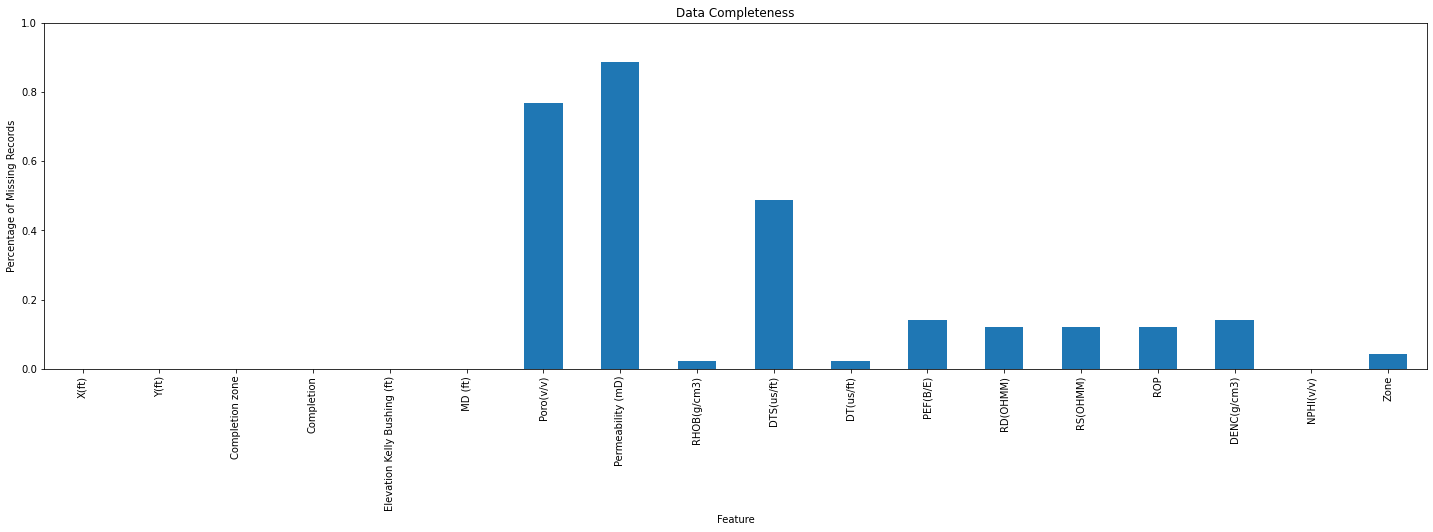

In [7]:
(wells_df.isnull().sum()/len(wells_df)).plot(kind = 'bar')
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2) # plot formatting
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Records'); plt.title('Data Completeness')
plt.ylim([0,1.0])
plt.show()

## FEATURE IMPUTATION  
- We first drop the features that are not insightful for our analysis

In [8]:
# DROP UNUSEFUL COLUMNS
df_imputed = wells_df.copy(deep=True)   # make a deep copy of the DataFrame
df_imputed.drop(['Elevation Kelly Bushing (ft)','Completion', 'DTS(us/ft)', 'DT(us/ft)', 'PEF(B/E)', 'RD(OHMM)', 'RS(OHMM)', 'ROP', 'DENC(g/cm3)', 'Zone'], axis=1, inplace=True)
df_imputed.head()

,X(ft),Y(ft),Completion zone,MD (ft),Poro(v/v),Permeability (mD),RHOB(g/cm3),NPHI(v/v)
Well_ID,,,,,,,,
Well_0,137106.82,83818.47,0,4597.471739,NaN,NaN,2.700700,0.000000
Well_0,137106.82,83818.47,0,4604.031739,0.087413,NaN,2.819380,0.121538
Well_0,137106.82,83818.47,0,4610.591739,NaN,NaN,2.798909,0.248546
Well_0,137106.82,83818.47,0,4617.151739,0.059590,NaN,2.575396,0.142681
Well_0,137106.82,83818.47,0,4623.711739,NaN,NaN,2.895991,0.353600


In [9]:
df_imputed.describe().T

,count,mean,std,min,25%,50%,75%,max
X(ft),1963.0,124890.354575,9775.363008,109560.260000,115987.290000,124094.800000,134042.860000,142095.820000
Y(ft),1963.0,87551.832639,3210.182762,81747.120000,84476.470000,88549.740000,89987.000000,93691.550000
Completion zone,1963.0,0.590932,0.491787,0.000000,0.000000,1.000000,1.000000,1.000000
MD (ft),1963.0,4673.224657,165.718326,4228.005683,4546.547857,4666.802978,4796.413228,5096.702794
Poro(v/v),455.0,0.131140,0.062887,0.019566,0.072468,0.129662,0.185373,0.249241
Permeability (mD),221.0,10.497034,39.248645,0.000001,0.019500,0.094813,1.948104,352.697773
RHOB(g/cm3),1918.0,2.472862,0.207148,1.991035,2.326909,2.469486,2.578890,3.044163
NPHI(v/v),1963.0,0.200208,0.107532,0.000000,0.122878,0.186431,0.244933,1.021738


- **DENSITY IMPUTATION:**  Bulk density includes the matrix and any fluid saturated pore volume within. Therefore a K Nearest Neighbors is a good method for this feature

In [10]:
df_knn = df_imputed.copy(deep=True)   # make a deep copy of the DataFrame
knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
df_knn.iloc[:,:] = knn_imputer.fit_transform(df_knn)

In [11]:
df_imputed['RHOB(g/cm3)'] = df_knn['RHOB(g/cm3)']
df_imputed.describe().T

,count,mean,std,min,25%,50%,75%,max
X(ft),1963.0,124890.354575,9775.363008,109560.260000,115987.290000,124094.800000,134042.860000,142095.820000
Y(ft),1963.0,87551.832639,3210.182762,81747.120000,84476.470000,88549.740000,89987.000000,93691.550000
Completion zone,1963.0,0.590932,0.491787,0.000000,0.000000,1.000000,1.000000,1.000000
MD (ft),1963.0,4673.224657,165.718326,4228.005683,4546.547857,4666.802978,4796.413228,5096.702794
Poro(v/v),455.0,0.131140,0.062887,0.019566,0.072468,0.129662,0.185373,0.249241
Permeability (mD),221.0,10.497034,39.248645,0.000001,0.019500,0.094813,1.948104,352.697773
RHOB(g/cm3),1963.0,2.474359,0.205946,1.991035,2.329274,2.472083,2.580801,3.044163
NPHI(v/v),1963.0,0.200208,0.107532,0.000000,0.122878,0.186431,0.244933,1.021738


- **POROSITY IMPUTATION:** for porosity, we have some core measurements (hard data) and porosity from logs (NPHI). We wanted to decided to cross validate the core measurements with the porosity log. We initially tried a LINEAR REGRESSION  between NPHI and Poro(v/v). However, the fit was not very convincing. Then, we tried a multilinear regression with 2 features: NPHI  and RHOB

In [12]:
porosity_df = (wells_df[['Poro(v/v)', 'NPHI(v/v)', 'RHOB(g/cm3)', 'Completion zone']])
porosity_df.head()

,Poro(v/v),NPHI(v/v),RHOB(g/cm3),Completion zone
Well_ID,,,,
Well_0,NaN,0.000000,2.700700,0
Well_0,0.087413,0.121538,2.819380,0
Well_0,NaN,0.248546,2.798909,0
Well_0,0.059590,0.142681,2.575396,0
Well_0,NaN,0.353600,2.895991,0


In [13]:
porosity_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Poro(v/v),455.0,0.131140,0.062887,0.019566,0.072468,0.129662,0.185373,0.249241
NPHI(v/v),1963.0,0.200208,0.107532,0.000000,0.122878,0.186431,0.244933,1.021738
RHOB(g/cm3),1918.0,2.472862,0.207148,1.991035,2.326909,2.469486,2.578890,3.044163
Completion zone,1963.0,0.590932,0.491787,0.000000,0.000000,1.000000,1.000000,1.000000


In [14]:
porosity2_df = porosity_df.dropna()
porosity2_df.head()

,Poro(v/v),NPHI(v/v),RHOB(g/cm3),Completion zone
Well_ID,,,,
Well_0,0.087413,0.121538,2.819380,0
Well_0,0.059590,0.142681,2.575396,0
Well_0,0.082269,0.226349,2.831982,0
Well_0,0.062989,0.188662,2.727031,0
Well_0,0.067931,0.317625,2.974074,0


In [15]:
porosity2_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Poro(v/v),455.0,0.131140,0.062887,0.019566,0.072468,0.129662,0.185373,0.249241
NPHI(v/v),455.0,0.203304,0.110743,0.000000,0.121647,0.188193,0.245365,0.786988
RHOB(g/cm3),455.0,2.475084,0.213178,2.021383,2.336362,2.468460,2.589938,3.041181
Completion zone,455.0,0.542857,0.498708,0.000000,0.000000,1.000000,1.000000,1.000000


In [16]:
por_upper_df = porosity2_df[porosity2_df['Completion zone']==0]
por_upper_df.describe().T


,count,mean,std,min,25%,50%,75%,max
Poro(v/v),208.0,0.120982,0.062531,0.026224,0.066350,0.100764,0.181212,0.249241
NPHI(v/v),208.0,0.212739,0.113857,0.000000,0.120654,0.198926,0.280975,0.786988
RHOB(g/cm3),208.0,2.476278,0.251717,2.021383,2.274563,2.472102,2.609761,3.041181
Completion zone,208.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:
por_lower_df = porosity2_df[porosity2_df['Completion zone']==1]
por_lower_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Poro(v/v),247.0,0.139693,0.062030,0.019566,0.079900,0.148503,0.192791,0.244583
NPHI(v/v),247.0,0.195359,0.107642,0.042470,0.122611,0.182560,0.217577,0.740866
RHOB(g/cm3),247.0,2.474079,0.174791,2.036921,2.360671,2.467156,2.580999,2.955648
Completion zone,247.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
# Fitting a line
x1 = por_upper_df['NPHI(v/v)']
y1 = por_upper_df['Poro(v/v)']
c1 = np.polyfit(x1,y1,1) # Calculate the polynomial fit
ycalc1 = np.polyval(c1,x1) # Using the polynomial, calculate values for array x


x2 = por_lower_df['NPHI(v/v)']
y2 = por_lower_df['Poro(v/v)']
c2 = np.polyfit(x2,y2,1) # Calculate the polynomial fit
ycalc2 = np.polyval(c2,x2) # Using the polynomial, calculate values for array x



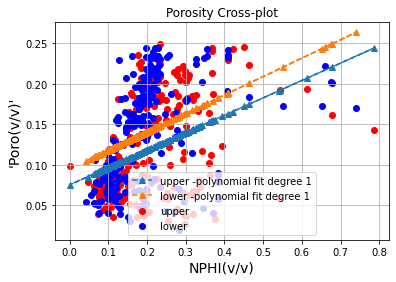

In [21]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.scatter(x1, y1, color='r', label='upper')
ax.scatter(x2, y2, color='b', label='lower')
#ax.plot(x1,y1,'o',label='values')
ax.plot(x1,ycalc1,'--^',label='upper -polynomial fit degree 1')
ax.plot(x2,ycalc2,'--^',label='lower -polynomial fit degree 1')
ax.legend(loc='best');

# set axis limits
# ax.set_xlim(0,10000)
# #ax.set_ylim(0,3000)
# set x-axis label
ax.set_xlabel('NPHI(v/v)',fontsize=14)
# set y-axis label
ax.set_ylabel("'Poro(v/v)'",color="black",fontsize=14)
ax.set_title('Porosity Cross-plot')
plt.grid()
plt.legend(loc=8)
# twin object for two different y-axis on the sample plot

#ax2=ax.twinx()
# make a plot with different y-axis using second axis object
#ax2.plot(df['Time (s)'], df['Ev(Lc)'], 'g', label='Ev')
#ax2.set_ylabel("Volumetric Strain [-]",color="green",fontsize=14)
#plt.legend(loc=9)

plt.show()
# save the plot as a file
# fig.savefig('He_porosity.png',dpi=300, facecolor='w', edgecolor='w',
#         orientation='portrait', format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         metadata=None)

In [ ]:
#MERGE WITH CUMULATIVE PRODUCTION
production_history_df = pd.read_csv('Well_Production.csv', index_col='Well_ID')
# production_history_df.head()
production_df = wells_df.merge(production_history_df, how='left', left_index=True, right_index=True)
production_df.head()

#### Summary Statistics

Summary statistics of one variable at a time. The describe command provides count, mean, minimum, maximum, and quartiles all in a compact data table. We use transpose() command to flip the table so that features are on the rows and the statistics are on the columns.

#### MULTILINEAR REGRESSION

In [22]:
# Select 2 predictor features here:
predictor_features = ['NPHI(v/v)','RHOB(g/cm3)']           # for the first demonstration run we will use porosity and brittleness
#

response_feature = 'Poro(v/v)'

pindex = np.argwhere(por_upper_df.columns.isin(predictor_features)).ravel()
print('Selected predictor features: \n0: ' + predictor_features[0] + ', index = ' + str(pindex[0]) + '.')
print('1: ' + predictor_features[1] + ', index = ' + str(pindex[1]) + '.')
rindex = np.argwhere(por_upper_df.columns.isin([response_feature])).ravel()
print('\nSelected response feature: \n' + response_feature + ', index = ' + str(rindex[0]) + '.')

#my_data_cut = my_data.iloc[0:500,:] 
X = por_upper_df[predictor_features]                # extract the 2 selected response features, 500 samples to a X array
y = por_upper_df[[response_feature]]    

Selected predictor features: 
0: NPHI(v/v), index = 1.
1: RHOB(g/cm3), index = 2.

Selected response feature: 
Poro(v/v), index = 0.


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73073)
n_train = len(X_train)
n_test = len(X_test)
print('Number of training ' + str(n_train) + ', number of test ' + str(n_test))

Number of training 166, number of test 42


NPHI(v/v) Coef: 0.091, RHOB(g/cm3) Coef:  -0.191, Intercept:  0.573
Variance explained: 0.70


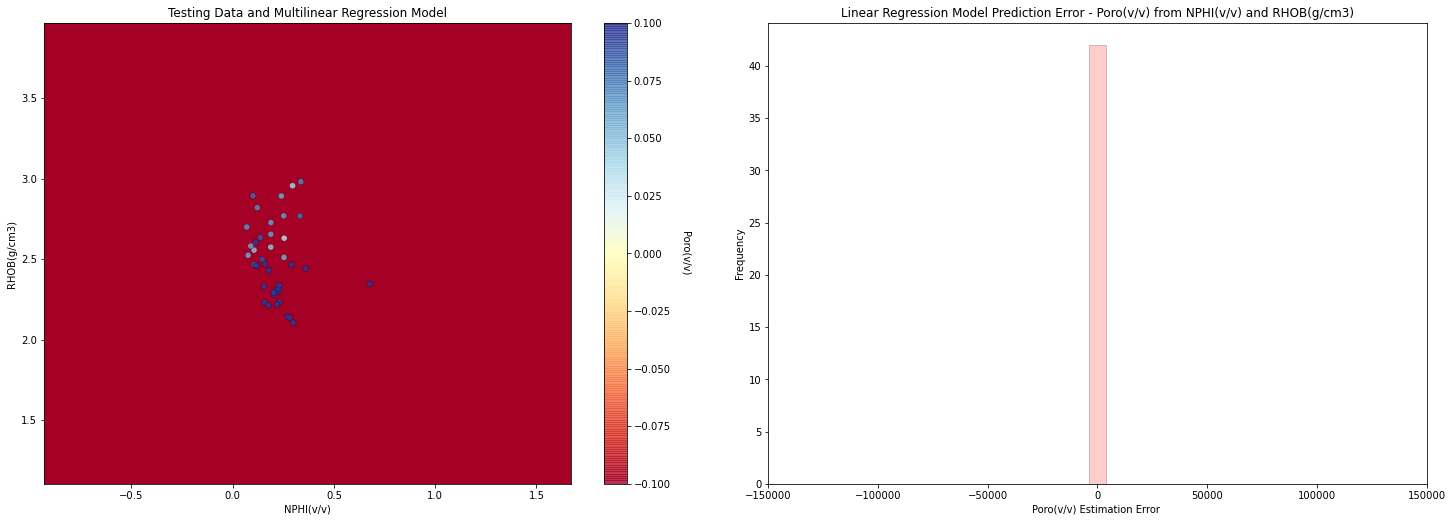

In [24]:
# Step 1. Instantiate the Model 
multilinear_reg = linear_model.LinearRegression()

# Step 2: Fit the Data on Training Data
multilinear_reg.fit(X_train.values.reshape(n_train,2), y_train[response_feature]) # fit model

# Print the model parameters
print(predictor_features[0] + ' Coef: ' + str(round(multilinear_reg.coef_[0],3)) + ', ' + predictor_features[1] + ' Coef: ', str(round(multilinear_reg.coef_[1],3)) + ', Intercept: ', str(round(multilinear_reg.intercept_,3))) 

# Plot model fit
plt.subplot(121)
plt = visualize_model(multilinear_reg,X_test[predictor_features[0]],X_test[predictor_features[1]],y_test[response_feature],'Testing Data and Multilinear Regression Model')

# Step 3: - Make predictions using the testing dataset
multilinear_y_pred = multilinear_reg.predict(X_test.values.reshape(n_test,2))

# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(y_test, multilinear_y_pred))

# Calculate the error at withheld testing samples
multilinear_y_res = multilinear_y_pred - y_test[response_feature].values

plt.subplot(122)
plt.hist(multilinear_y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(-1*fmax[rindex[0]],fmax[rindex[0]],40))
plt.title('Linear Regression Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0] + ' and ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error '); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.6, wspace=0.1, hspace=0.2)
plt.show()


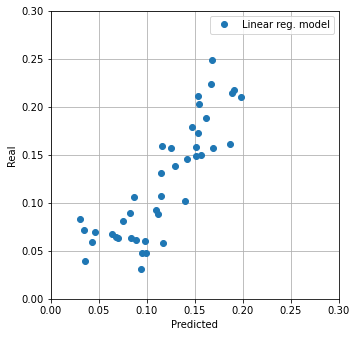

In [25]:
#Plot the model 
fig,ax = plt.subplots()
# make a plot
plt.plot(multilinear_y_pred, y_test, 'o', label="Linear reg. model")
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)
plt.grid()
plt.xlabel("Predicted"); plt.ylabel("Real"); plt.legend();
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.3, top=1, wspace=0.2, hspace=0.3)
ax.set_aspect('equal', adjustable='box')
plt.show()


#### MultiLinear Regression for LOWER  completion zone

In [26]:
# Select 2 predictor features here:
predictor_features = ['NPHI(v/v)','RHOB(g/cm3)']           # for the first demonstration run we will use porosity and brittleness
#

response_feature = 'Poro(v/v)'

pindex = np.argwhere(por_upper_df.columns.isin(predictor_features)).ravel()
print('Selected predictor features: \n0: ' + predictor_features[0] + ', index = ' + str(pindex[0]) + '.')
print('1: ' + predictor_features[1] + ', index = ' + str(pindex[1]) + '.')
rindex = np.argwhere(por_upper_df.columns.isin([response_feature])).ravel()
print('\nSelected response feature: \n' + response_feature + ', index = ' + str(rindex[0]) + '.')

#my_data_cut = my_data.iloc[0:500,:] 
X = por_lower_df[predictor_features]                # extract the 2 selected response features, 500 samples to a X array
y = por_lower_df[[response_feature]]    

Selected predictor features: 
0: NPHI(v/v), index = 1.
1: RHOB(g/cm3), index = 2.

Selected response feature: 
Poro(v/v), index = 0.


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73073)
n_train = len(X_train)
n_test = len(X_test)
print('Number of training ' + str(n_train) + ', number of test ' + str(n_test))

Number of training 197, number of test 50


NPHI(v/v) Coef: 0.067, RHOB(g/cm3) Coef:  -0.278, Intercept:  0.816
Variance explained: 0.75


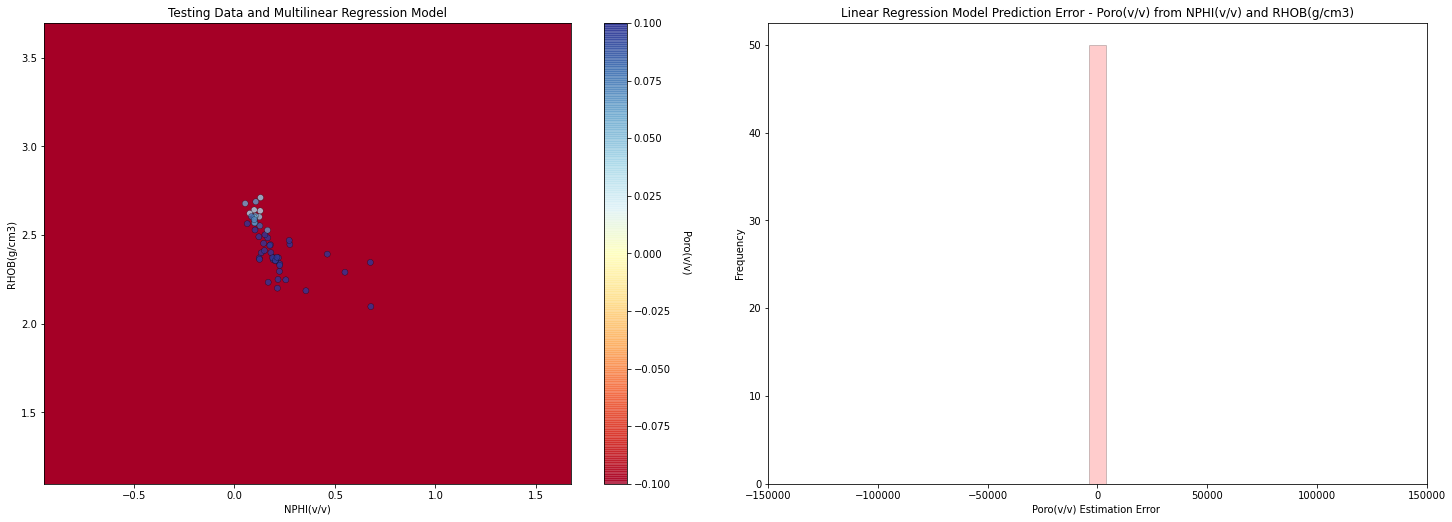

In [28]:
# Step 1. Instantiate the Model 
multilinear_reg = linear_model.LinearRegression()

# Step 2: Fit the Data on Training Data
multilinear_reg.fit(X_train.values.reshape(n_train,2), y_train[response_feature]) # fit model

# Print the model parameters
print(predictor_features[0] + ' Coef: ' + str(round(multilinear_reg.coef_[0],3)) + ', ' + predictor_features[1] + ' Coef: ', str(round(multilinear_reg.coef_[1],3)) + ', Intercept: ', str(round(multilinear_reg.intercept_,3))) 

# Plot model fit
plt.subplot(121)
plt = visualize_model(multilinear_reg,X_test[predictor_features[0]],X_test[predictor_features[1]],y_test[response_feature],'Testing Data and Multilinear Regression Model')

# Step 3: - Make predictions using the testing dataset
multilinear_y_pred = multilinear_reg.predict(X_test.values.reshape(n_test,2))

# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(y_test, multilinear_y_pred))

# Calculate the error at withheld testing samples
multilinear_y_res = multilinear_y_pred - y_test[response_feature].values

plt.subplot(122)
plt.hist(multilinear_y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(-1*fmax[rindex[0]],fmax[rindex[0]],40))
plt.title('Linear Regression Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0] + ' and ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error '); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.6, wspace=0.1, hspace=0.2)
plt.show()

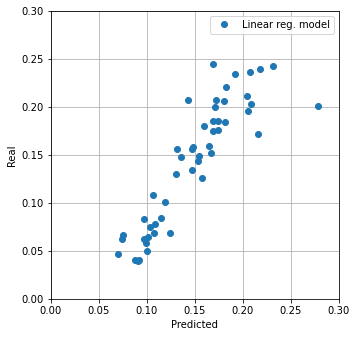

In [29]:
#Plot the model 
fig,ax = plt.subplots()
#plt.scatter(train.ENGINESIZE, train.CO2EMISSIONS,  color='blue', label="Training")
plt.plot(multilinear_y_pred, y_test, 'o', label="Linear reg. model")
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)
plt.grid()
plt.xlabel("Predicted"); plt.ylabel("Real"); plt.legend();
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.3, top=1, wspace=0.2, hspace=0.3)
ax.set_aspect('equal', adjustable='box')
plt.show()

In [30]:
df_por = df_imputed.copy(deep=True)   # make a deep copy of the DataFrame
len(df_por)

1963

In [31]:
import math
df_por = df_imputed.copy(deep=True)   # make a deep copy of the DataFrame

for i in range(len(df_por)):
    if (math.isnan(df_por['Poro(v/v)'][i]) and df_por['Completion zone'][i]==0) :
        #print(i,df_por['Completion zone'][i], math.isnan(df_por['Poro(v/v)'][i]))
        df_por['Poro(v/v)'][i]= (0.091*df_por['NPHI(v/v)'][i])-(0.191*df_por['RHOB(g/cm3)'][i])+0.573
    elif (math.isnan(df_por['Poro(v/v)'][i]) and df_por['Completion zone'][i]==1):
        #print(i,df_por['Completion zone'][i], math.isnan(df_por['Poro(v/v)'][i]))
        df_por['Poro(v/v)'][i] = (0.067*df_por['NPHI(v/v)'][i])-(0.278*df_por['RHOB(g/cm3)'][i])+0.816
df_por.head(n=5)

C:\Users\monic\AppData\Local\Temp/ipykernel_45676/2748408581.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_por['Poro(v/v)'][i]= (0.091*df_por['NPHI(v/v)'][i])-(0.191*df_por['RHOB(g/cm3)'][i])+0.573
C:\Users\monic\AppData\Local\Temp/ipykernel_45676/2748408581.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_por['Poro(v/v)'][i] = (0.067*df_por['NPHI(v/v)'][i])-(0.278*df_por['RHOB(g/cm3)'][i])+0.816


,X(ft),Y(ft),Completion zone,MD (ft),Poro(v/v),Permeability (mD),RHOB(g/cm3),NPHI(v/v)
Well_ID,,,,,,,,
Well_0,137106.82,83818.47,0,4597.471739,0.057166,NaN,2.700700,0.000000
Well_0,137106.82,83818.47,0,4604.031739,0.087413,NaN,2.819380,0.121538
Well_0,137106.82,83818.47,0,4610.591739,0.061026,NaN,2.798909,0.248546
Well_0,137106.82,83818.47,0,4617.151739,0.059590,NaN,2.575396,0.142681
Well_0,137106.82,83818.47,0,4623.711739,0.052043,NaN,2.895991,0.353600


In [32]:
# prevent negative values with truncation
num = df_por._get_numeric_data()                    # get the numerical values
num[num < 0] = 0                                          # truncate negative values to 0.0
df_imputed['Poro(v/v)'] = df_por['Poro(v/v)']
df_imputed.describe().T

,count,mean,std,min,25%,50%,75%,max
X(ft),1963.0,124890.354575,9775.363008,109560.260000,115987.290000,124094.800000,134042.860000,142095.820000
Y(ft),1963.0,87551.832639,3210.182762,81747.120000,84476.470000,88549.740000,89987.000000,93691.550000
Completion zone,1963.0,0.590932,0.491787,0.000000,0.000000,1.000000,1.000000,1.000000
MD (ft),1963.0,4673.224657,165.718326,4228.005683,4546.547857,4666.802978,4796.413228,5096.702794
Poro(v/v),1963.0,0.132445,0.056066,0.000000,0.093060,0.129367,0.173578,0.323677
Permeability (mD),221.0,10.497034,39.248645,0.000001,0.019500,0.094813,1.948104,352.697773
RHOB(g/cm3),1963.0,2.474359,0.205946,1.991035,2.329274,2.472083,2.580801,3.044163
NPHI(v/v),1963.0,0.200208,0.107532,0.000000,0.122878,0.186431,0.244933,1.021738


- **PERMEABILITY IMPUTATION** Same as core porosity. We only have permeability measurements where cores were acquired. Then we decided to use Carman Kozeny model to calcularte the permeability using our porosity values. Where κ is the permeability and ϕ is the porosity.  

$\kappa \sim \phi^3/(1−\phi)^2$
 


C:\Users\monic\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


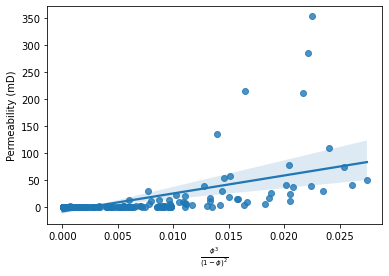

In [35]:
# Pipeline designed by Dr. John Foster 
df_perm = df_imputed.copy(deep=True)   # make a deep copy of the DataFrame
# print(len(missing_perms))
missing_perms = df_perm['Permeability (mD)'].isnull()
phi = df_perm.loc[~missing_perms, 'Poro(v/v)'].to_numpy()
fig, ax = plt.subplots()
sns.regplot(phi ** 3 / (1 - phi) ** 2, 
            wells_df.loc[~missing_perms, 'Permeability (mD)'], ax=ax);
ax.set_xlabel(r'$\frac{\phi^3}{(1 - \phi)^2}$');


In [36]:
fphi = lambda phi, m, kappa0: m * phi ** 3 / (1 - phi) ** 2 + kappa0
popt, _ = curve_fit(fphi, phi, wells_df.loc[~missing_perms, 'Permeability (mD)'])

In [37]:
df_perm['KC permeability (mD)'] = fphi(df_perm['Poro(v/v)'], 
                                      popt[0], popt[1])

In [38]:
df_perm.describe().T

,count,mean,std,min,25%,50%,75%,max
X(ft),1963.0,124890.354575,9775.363008,109560.260000,115987.290000,124094.800000,134042.860000,142095.820000
Y(ft),1963.0,87551.832639,3210.182762,81747.120000,84476.470000,88549.740000,89987.000000,93691.550000
Completion zone,1963.0,0.590932,0.491787,0.000000,0.000000,1.000000,1.000000,1.000000
MD (ft),1963.0,4673.224657,165.718326,4228.005683,4546.547857,4666.802978,4796.413228,5096.702794
Poro(v/v),1963.0,0.132445,0.056066,0.000000,0.093060,0.129367,0.173578,0.323677
Permeability (mD),221.0,10.497034,39.248645,0.000001,0.019500,0.094813,1.948104,352.697773
RHOB(g/cm3),1963.0,2.474359,0.205946,1.991035,2.329274,2.472083,2.580801,3.044163
NPHI(v/v),1963.0,0.200208,0.107532,0.000000,0.122878,0.186431,0.244933,1.021738
KC permeability (mD),1963.0,10.937444,22.481392,-7.243402,-4.001010,2.208734,18.096608,238.090327


In [39]:
scalers = [MaxAbsScaler(), MinMaxScaler(), StandardScaler(), RobustScaler()]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('poly', PolynomialFeatures()),
    ('reg', LinearRegression())
])

params = {
    'scaler': scalers,
    'poly__degree': [2, 3, 4],
    'pca__n_components': [1, 2, 3, 4, 5, 6, 7],
}

gcv = GridSearchCV(pipe, params, cv=KFold(random_state=5, shuffle=True))
gcv.fit(df_perm[~missing_perms].drop('Permeability (mD)', axis=1), 
        df_perm.loc[~missing_perms, 'Permeability (mD)'])
gcv.best_params_

{'pca__n_components': 1, 'poly__degree': 2, 'scaler': RobustScaler()}

In [40]:
df_perm.loc[missing_perms, 'Permeability (mD)'] = \
    gcv.predict(df_perm[missing_perms].drop('Permeability (mD)', axis=1))

In [41]:
# prevent negative values with truncation
num = df_perm._get_numeric_data()                    # get the numerical values
num[num < 0] = 0                                          # truncate negative values to 0.0
df_perm.describe().T

,count,mean,std,min,25%,50%,75%,max
X(ft),1963.0,124890.354575,9775.363008,109560.260000,115987.290000,124094.800000,134042.860000,142095.820000
Y(ft),1963.0,87551.832639,3210.182762,81747.120000,84476.470000,88549.740000,89987.000000,93691.550000
Completion zone,1963.0,0.590932,0.491787,0.000000,0.000000,1.000000,1.000000,1.000000
MD (ft),1963.0,4673.224657,165.718326,4228.005683,4546.547857,4666.802978,4796.413228,5096.702794
Poro(v/v),1963.0,0.132445,0.056066,0.000000,0.093060,0.129367,0.173578,0.323677
Permeability (mD),1963.0,12.417411,33.259635,0.000000,0.000000,0.063276,8.568973,673.495316
RHOB(g/cm3),1963.0,2.474359,0.205946,1.991035,2.329274,2.472083,2.580801,3.044163
NPHI(v/v),1963.0,0.200208,0.107532,0.000000,0.122878,0.186431,0.244933,1.021738
KC permeability (mD),1963.0,12.824067,21.218079,0.000000,0.000000,2.208734,18.096608,238.090327


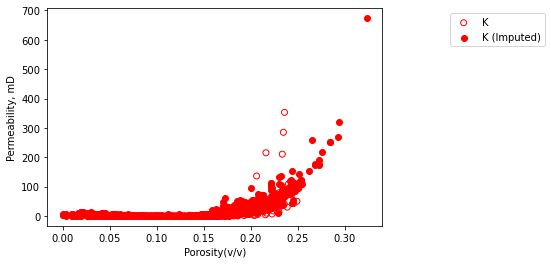

In [42]:
fig, ax = plt.subplots()
ax.scatter(df_perm[~missing_perms]['Poro(v/v)'], df_perm[~missing_perms]['Permeability (mD)'], 
           color='r', facecolors='none', label='K')
ax.scatter(df_perm[missing_perms]['Poro(v/v)'], 
           df_perm[missing_perms]['Permeability (mD)'], 
           color='r', label='K (Imputed)')
ax.set_xlabel('Porosity(v/v)')
ax.set_ylabel('Permeability, mD')
ax.legend(bbox_to_anchor=(1.5, 1), loc='upper right', ncol=1);


In [43]:
#The 'KC permeability, mD' is redundant now, so we'll drop it from the dataframe.

df_perm.drop('KC permeability (mD)', axis=1, inplace=True)
df_imputed['Permeability (mD)'] = df_perm['Permeability (mD)'] 

In [44]:
df_imputed.describe().T

,count,mean,std,min,25%,50%,75%,max
X(ft),1963.0,124890.354575,9775.363008,109560.260000,115987.290000,124094.800000,134042.860000,142095.820000
Y(ft),1963.0,87551.832639,3210.182762,81747.120000,84476.470000,88549.740000,89987.000000,93691.550000
Completion zone,1963.0,0.590932,0.491787,0.000000,0.000000,1.000000,1.000000,1.000000
MD (ft),1963.0,4673.224657,165.718326,4228.005683,4546.547857,4666.802978,4796.413228,5096.702794
Poro(v/v),1963.0,0.132445,0.056066,0.000000,0.093060,0.129367,0.173578,0.323677
Permeability (mD),1963.0,12.417411,33.259635,0.000000,0.000000,0.063276,8.568973,673.495316
RHOB(g/cm3),1963.0,2.474359,0.205946,1.991035,2.329274,2.472083,2.580801,3.044163
NPHI(v/v),1963.0,0.200208,0.107532,0.000000,0.122878,0.186431,0.244933,1.021738


- **UPSCALING: from Well-log scale to Well scale** We have multiple entries per well. Now we will upscale to average properties for the entire well

In [45]:
df_imputed['Zone']=well_logs_df['Zone']
df_imputed.head(n=10)

,X(ft),Y(ft),Completion zone,MD (ft),Poro(v/v),Permeability (mD),RHOB(g/cm3),NPHI(v/v),Zone
Well_ID,,,,,,,,,
Well_0,137106.82,83818.47,0,4597.471739,0.057166,7.888303,2.700700,0.000000,Upper
Well_0,137106.82,83818.47,0,4604.031739,0.087413,4.408944,2.819380,0.121538,Upper
Well_0,137106.82,83818.47,0,4610.591739,0.061026,1.353763,2.798909,0.248546,Upper
Well_0,137106.82,83818.47,0,4617.151739,0.059590,0.000000,2.575396,0.142681,Upper
Well_0,137106.82,83818.47,0,4623.711739,0.052043,1.461211,2.895991,0.353600,Upper
Well_0,137106.82,83818.47,0,4630.271739,0.082269,1.532611,2.831982,0.226349,Upper
Well_0,137106.82,83818.47,0,4636.831739,0.055201,5.250441,2.774357,0.133007,Upper
Well_0,137106.82,83818.47,0,4643.391739,0.062989,1.049195,2.727031,0.188662,Upper
Well_0,137106.82,83818.47,0,4649.951739,0.030784,11.701884,2.926972,0.185004,Upper


In [46]:
df_mean =  df_imputed.copy(deep=True)   # make a deep copy of the DataFrame
df_mean.drop(['RHOB(g/cm3)','NPHI(v/v)' ,'Zone'], axis=1, inplace=True)
well_summary_df = df_mean.groupby(df_mean.index).mean()

In [47]:
well_summary_df.head(50)

,X(ft),Y(ft),Completion zone,MD (ft),Poro(v/v),Permeability (mD)
Well_ID,,,,,,
Well_0,137106.820000,83818.470000,0.000000,4725.391739,0.113747,6.264939
Well_1,132460.980000,85832.770000,0.000000,4868.900545,0.126777,13.832289
Well_10,134042.860000,82411.270000,0.000000,4818.174657,0.129069,4.255848
Well_11,115725.490000,86866.600000,0.000000,4661.109023,0.094573,0.835988
Well_12,133136.980000,93691.550000,1.000000,4808.270995,0.142815,4.875138
Well_13,119311.270000,89234.020000,0.000000,4531.991055,0.118740,1.796602
Well_14,134837.260000,83865.820000,1.000000,4781.602978,0.138829,3.554240
Well_15,110709.214545,86698.720000,1.000000,4405.841183,0.174725,57.085945
Well_16,112898.580000,91601.460000,1.000000,4562.928038,0.138667,8.181189


In [48]:
from scipy.interpolate import NearestNDInterpolator


#Separete dataset in UPPER and Lower
df = pd.read_csv('Well_Head_and_Completion.csv', index_col='Well_ID')
df_Upper=df[df["Completion"] =="Upper"]
df_Lower=df[df["Completion"] =="Lower"]

df_AI = pd.read_csv('AI.csv')
df_AI.describe()

#Inpute the AI for each well location from the AI MAP 2020
x = df_AI['X(ft)']
y = df_AI['Y(ft)']
AIu= df_AI['AI_upper(2021-12-20)']
X= np.linspace(min(x), max(x))
Y= np.linspace(min(y), max(y))
X, Y= np.meshgrid(X, Y)  # 2D grid for interpolation
interp_upper= NearestNDInterpolator(list(zip(x, y)), AIu)
Xu=df_Upper['X(ft)']
Yu=df_Upper['Y(ft)']
AIu = interp_upper(Xu, Yu)


AIl= df_AI['AI_lower(2021-12-20)']
interp = NearestNDInterpolator(list(zip(x, y)), AIl)
Xl=df_Lower['X(ft)']
Yl=df_Lower['Y(ft)']
AIl = interp(Xl, Yl)

df_Upper["AI"]=AIu
df_Lower["AI"]=AIl

wells_df1 = pd.concat([df_Lower, df_Upper])
wells_df1 =wells_df1.sort_values(by='Well_ID')

C:\Users\monic\AppData\Local\Temp/ipykernel_45676/1377743939.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Upper["AI"]=AIu
C:\Users\monic\AppData\Local\Temp/ipykernel_45676/1377743939.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Lower["AI"]=AIl


In [49]:
wells_df1.head()

,X(ft),Y(ft),Completion,Elevation Kelly Bushing (ft),WOPR (bpd),Np (bls),AI
Well_ID,,,,,,,
Well_0,137106.82,83818.47,Upper,193.32,8.809168,14473.503510,6527.288321
Well_1,132460.98,85832.77,Upper,187.15,38.675641,30591.819370,6523.526063
Well_10,134042.86,82411.27,Upper,184.33,46.363101,48077.967090,6473.198759
Well_11,115725.49,86866.60,Upper,192.03,0.000000,0.000000,6430.629923
Well_12,133136.98,93691.55,Lower,170.35,0.664632,1759.350823,6362.714848


In [50]:
wells_df1.drop(['X(ft)', 'Y(ft)', 'Completion', 'Elevation Kelly Bushing (ft)'], axis=1, inplace=True)
wells_df1.head()

,WOPR (bpd),Np (bls),AI
Well_ID,,,
Well_0,8.809168,14473.503510,6527.288321
Well_1,38.675641,30591.819370,6523.526063
Well_10,46.363101,48077.967090,6473.198759
Well_11,0.000000,0.000000,6430.629923
Well_12,0.664632,1759.350823,6362.714848


In [51]:
wells_df2 =  wells_df1.copy(deep=True)   # make a deep copy of the DataFrame
# wells_df2.head()
wells_df2 = well_summary_df.merge(wells_df2, how='left', 
                              left_index=True, 
                              right_index=True)
wells_df2.head()

,X(ft),Y(ft),Completion zone,MD (ft),Poro(v/v),Permeability (mD),WOPR (bpd),Np (bls),AI
Well_ID,,,,,,,,,
Well_0,137106.82,83818.47,0.0,4725.391739,0.113747,6.264939,8.809168,14473.503510,6527.288321
Well_1,132460.98,85832.77,0.0,4868.900545,0.126777,13.832289,38.675641,30591.819370,6523.526063
Well_10,134042.86,82411.27,0.0,4818.174657,0.129069,4.255848,46.363101,48077.967090,6473.198759
Well_11,115725.49,86866.60,0.0,4661.109023,0.094573,0.835988,0.000000,0.000000,6430.629923
Well_12,133136.98,93691.55,1.0,4808.270995,0.142815,4.875138,0.664632,1759.350823,6362.714848


In [52]:
wells_df2.to_csv('Wells_feature_ranking.csv') 

In [53]:
wells_df3 = pd.read_csv('Wells_feature_ranking.csv', usecols=['Well_ID','X(ft)', 'Y(ft)', 'Completion zone', ' MD (ft)', 'Poro(v/v)', 'Permeability (mD)', 'Np (bls)'], index_col='Well_ID')
wells_df3.head()

,X(ft),Y(ft),Completion zone,MD (ft),Poro(v/v),Permeability (mD),Np (bls)
Well_ID,,,,,,,
Well_0,137106.82,83818.47,0.0,4725.391739,0.113747,6.264939,14473.503510
Well_1,132460.98,85832.77,0.0,4868.900545,0.126777,13.832289,30591.819370
Well_10,134042.86,82411.27,0.0,4818.174657,0.129069,4.255848,48077.967090
Well_11,115725.49,86866.60,0.0,4661.109023,0.094573,0.835988,0.000000
Well_12,133136.98,93691.55,1.0,4808.270995,0.142815,4.875138,1759.350823


### FEATURE RANKING

In [54]:
def partial_corr(C):
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.

#    Parameters
#    C : array-like, shape (n, p)
#        Array with the different variables. Each column of C is taken as a variable
#    Returns
#    P : array-like, shape (p, p)
#        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
#        for the remaining variables in C.

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def semipartial_corr(C): # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] # just use the value, not a residual
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

In [55]:
partial_correlation = partial_corr(wells_df3.iloc[:,:8]) # calculate the partial correlation coefficients
partial_correlation = partial_correlation[:,6][:6] # extract a single row and remove production with itself

C:\Users\monic\AppData\Local\Temp/ipykernel_45676/2152434617.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  P_corr = np.zeros((p, p), dtype=np.float)
C:\Users\monic\AppData\Local\Temp/ipykernel_45676/2152434617.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.ones(p, dtype=np.bool)


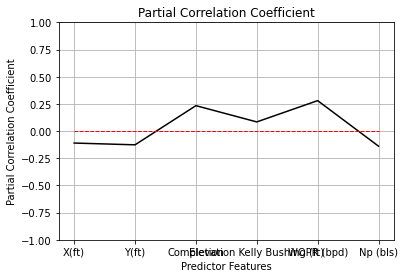

In [56]:
features = df.columns.values[:][:6]
plt.subplot()
plt.plot(features,partial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

## VISUALIZATION 

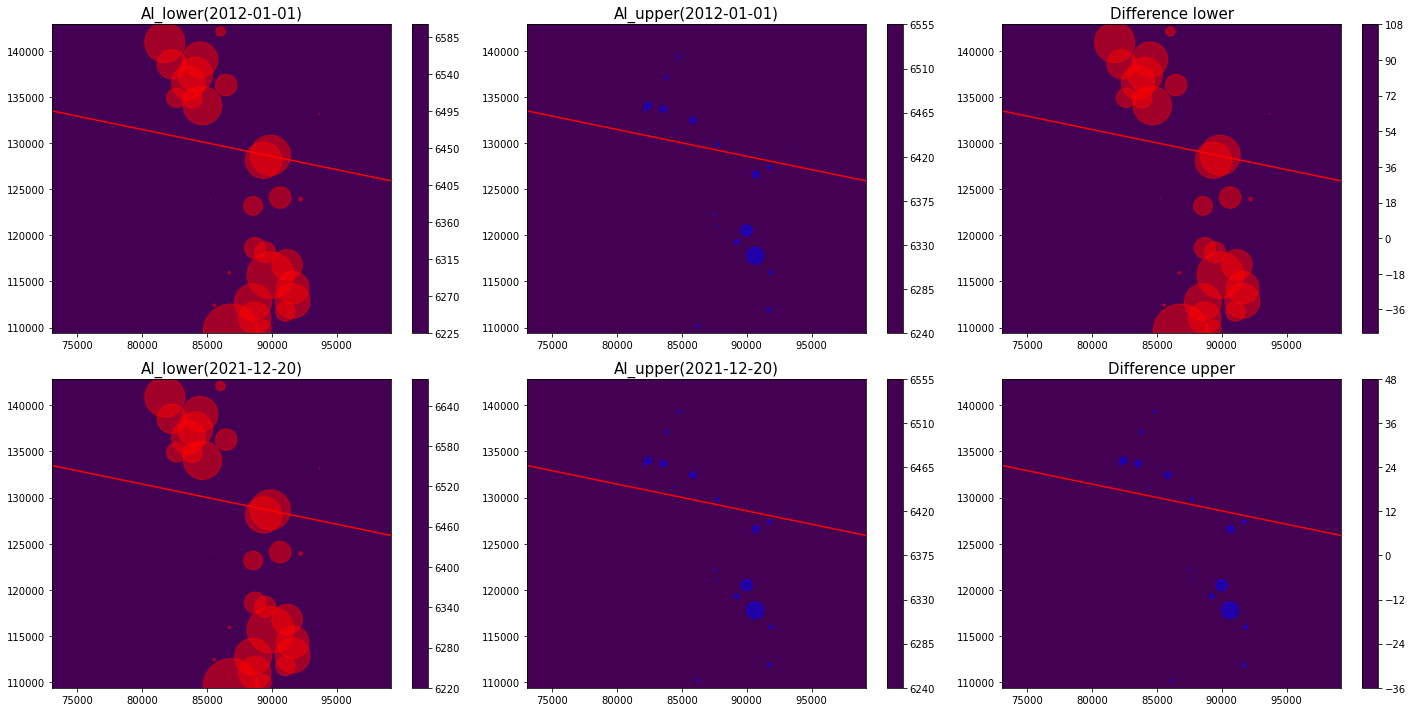

In [57]:
df_AI = pd.read_csv('AI.csv')
df_AI['Difference lower'] = df_AI['AI_lower(2021-12-20)'] - df_AI['AI_lower(2012-01-01)']
df_AI['Difference upper'] = df_AI['AI_upper(2021-12-20)'] - df_AI['AI_upper(2012-01-01)']

df_AI
     
location_AI = df_AI[['X(ft)', 'Y(ft)']]

df_head_completion = pd.read_csv('Well_Production.csv')
location_well = df_head_completion[['WOPR (bpd)','X(ft)','Y(ft)']] 

plt.figure(figsize=(20, 10))
for i, col in enumerate(['AI_lower(2012-01-01)', 'AI_upper(2012-01-01)','Difference lower',
                             'AI_lower(2021-12-20)', 'AI_upper(2021-12-20)','Difference upper']):
    ax = plt.subplot(2, 3, i+1)
    ai = df_AI[col]

    # Plot heatmap
    plt.title(col, fontsize=15)
    y = location_AI['X(ft)']
    x = location_AI['Y(ft)']
    xi = np.linspace(x.min(), x.max(), 1000)
    yi = np.linspace(y.min(), y.max(), 1000)
    zi = griddata((x.to_numpy(), y.to_numpy()), ai, (xi[None, :],yi[:, None]), method='cubic')

    cs = plt.contourf(xi, yi, zi, 25)
    for i in cs.collections:
        i.set_label('nolegend')
    cbar = plt.colorbar()

    # Plot the location of the wells
    upper = df_head_completion['Completion'].isin(['Upper'])
    location_upper = location_well.loc[upper]
    location_lower = location_well.loc[~upper]
    ax = plt.gca()
    if 'upper' in col:
        ax.scatter(location_upper['Y(ft)'], location_upper['X(ft)'], location_upper['WOPR (bpd)'],color='b', marker='o', alpha=0.5)
    else:
        ax.scatter(location_lower['Y(ft)'], location_lower['X(ft)'], location_lower['WOPR (bpd)'], color='r', marker='o', alpha=0.5)
    plt.clim(0,7e6)    
    Y1=np.linspace(x.min(), x.max(), 20000)
    X1=-0.29*Y1+154670
    ax.plot(Y1,X1,color = 'r')


plt.tight_layout()
plt.show()
